# Initialization

### Stream Generation and Sketch Setup

- **Stream Details**:
  - 100,000 elements sampled from 10,000 unique integers.
  - Shuffled for a realistic data flow, with reproducibility ensured by a fixed seed.

- **Sketch Sizes**: `[100, 300, 1000, 3000, 10000, 30000, 50000]`.

- **Purpose**: Prepares data to test the FM algorithm's accuracy in estimating unique elements with varying memory sizes.

In [276]:
import numpy as np

SEED = 42
NUM_ELEMENTS = 100000
NUM_UNIQUE = 10000
NUM_RUNS = 25

# Set the seed for reproducibility
np.random.seed(SEED)

stream = np.random.randint(0, NUM_UNIQUE, NUM_ELEMENTS)
np.random.shuffle(stream)

num_unique_elements = len(np.unique(stream))

print(f"Stream length: {len(stream)}")
print(f"Number of unique elements: {num_unique_elements}")
print(f"First 10 elements of the stream: {stream[:10]}")

sketch_sizes = [100, 300, 1000, 3000, 10000, 30000, 50000]
print(f"Sketch sizes: {sketch_sizes}")

Stream length: 100000
Number of unique elements: 10000
First 10 elements of the stream: [7373 4170 6775 6174 3168 6847 9084 1929 1287 1598]
Sketch sizes: [100, 300, 1000, 3000, 10000, 30000, 50000]


These functions hash elements and streams, ensuring uniform distribution between 0 and 1 for use in estimations.

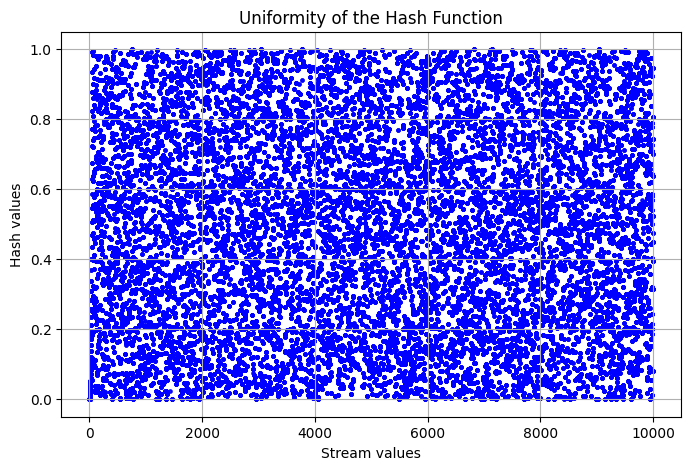

In [277]:
import matplotlib.pyplot as plt

P = 123457

def hash_stream(stream: np.ndarray, a: int, b: int, c: int, d: int, p: int = P) -> np.ndarray:
    """
    Hashes the stream using the given seed and returns a uniformly distributed number between 0 and 1.
    """
    return ((a * stream**3 + b * stream**2 + c * stream + d) % p) / p

# Plot the uniformity of the hash function
a, b, c, d = 1, 2, 3, 4
hashes = hash_stream(stream, a, b, c, d)

plt.figure(figsize=(8, 5))
plt.scatter(stream, hashes, alpha=0.7, color='blue', s=5)
plt.title("Uniformity of the Hash Function")
plt.xlabel("Stream values")
plt.ylabel("Hash values")
plt.grid(True)
plt.show()

## Flajolet Martin

### Flajolet Martin - Alpha Version

In [278]:
def flajolet_martin(stream: np.ndarray) -> float:
    """
    Flajolet-Martin algorithm for counting distinct elements in a stream.
    :param stream: numpy array of elements
    :return: estimated number of distinct elements
    """
    a, b, c, d = np.random.default_rng(SEED).integers(1, P, size=4)
    hashed_stream = hash_stream(stream, a, b, c, d)
    return 1 / np.min(hashed_stream)

# Sanity check
print(f"Estimated number of unique elements: {flajolet_martin(stream):.2f}")

Estimated number of unique elements: 10288.08


### Flajolet Martin - Beta Version

In [279]:
from typing import Optional

def flajolet_martin_beta(stream: np.ndarray, s: int) -> float:
    """
    Flajolet-Martin Beta algorithm for counting distinct elements in a stream.
    :param stream: numpy array of elements
    :param s: number of FM estimators to calculate
    :return: estimated number of distinct elements
    """
    abcd_vals = np.random.default_rng(SEED).integers(1, P, size=(s, 4))
    estimates = [hash_stream(stream, a, b, c, d) for a, b, c, d in abcd_vals]    
    Z = np.min(estimates, axis=1)
    return 1 / np.mean(Z) - 1

# Sanity check
print(f"Estimated number of unique elements: {flajolet_martin_beta(stream, 100):.2f}")

Estimated number of unique elements: 10044.32


### Flajolet Martin - Final Version

In [280]:
def flajolet_martin_final(stream: np.ndarray, t: int, s: int) -> float:
    """
    Flajolet-Martin Final algorithm that uses t instances of Flajolet-Martin Beta.
    :param stream: numpy array of elements
    :param t: number of Flajolet-Martin Beta instances to run
    :param s: number of FM estimators per Flajolet-Martin Beta instance
    :return: median of the distinct element estimates
    """
    abcd_vals = np.random.default_rng(SEED).integers(1, P, size=(t, s, 4))
    
    Zs = [np.min([hash_stream(stream, a, b, c, d) for a, b, c, d in abcd_vals[i]], axis=1) for i in range(t)]
    estimates = [1 / np.mean(Z) - 1 for Z in Zs]
        
    return np.median(estimates)

# Sanity check
print(f"Estimated number of unique elements: {flajolet_martin_final(stream, 3, 100):.2f}")

Estimated number of unique elements: 10118.43


Run 25 times for each sketch size

In [ ]:
from concurrent.futures import ThreadPoolExecutor

delta = 0.05  # 95% confidence interval
delta_beta = 1/3

def process_sketch(sketch_size: int) -> tuple:
    """
    Process a single sketch size.
    :param sketch_size: size of the sketch
    :return: tuple of FM, FM-beta, and FM-final estimates
    """
    # Maintain O(log(1/delta)/epsilon^2) space complexity to ensure 95% success probability
    epsilon = np.sqrt(np.log(1 / delta) / sketch_size)
    
    print("=====================================")
    print(f"Sketch size: {sketch_size}")
    print(f"Relative error (epsilon) that guarantees 95% success probability: {epsilon:.2f}") 
    
    # Calculate the number of FM-beta estimators and the number of FM estimators per FM-beta estimator
    t = int(np.ceil(np.log(1 / delta)))
    s = int(np.ceil(1 / (delta_beta * (epsilon**2))))
    print(f"FM-beta instances (t): {t}, FM instances per FM-beta (s): {s}")
    
    # Single run processing for each of the FM, FM-beta, and FM-final algorithms
    def process_run(sketch: np.ndarray, index: int) -> float:
        with ThreadPoolExecutor() as executor:
            fm_results = executor.submit(flajolet_martin, sketch).result()
            fm_beta_results = executor.submit(flajolet_martin_beta, sketch, s).result()
            fm_final_results = executor.submit(flajolet_martin_final, sketch, t, s).result()
        # print(f"Sketch size: {sketch_size}, Run: {index+1}/{NUM_RUNS}, FM estimate: {fm_results:.2f}, FM-beta estimate: {fm_beta_results:.2f}, FM-final estimate: {fm_final_results:.2f}")
        return fm_results, fm_beta_results, fm_final_results

    # Generate random indices for the stream
    indices = [np.random.choice(len(stream), size=sketch_size, replace=False) for _ in range(NUM_RUNS)]
    
    # Process the runs
    fm_results, fm_beta_results, fm_final_results = zip(*[process_run(stream[index], i) for i, index in enumerate(indices)])
    print(f"Average FM estimate: {np.mean(fm_results):.2f}, Average FM-beta estimate: {np.mean(fm_beta_results):.2f}, Average FM-final estimate: {np.mean(fm_final_results):.2f}")
    
    return fm_results, fm_beta_results, fm_final_results

print(f"True number of unique elements: {num_unique_elements}")
results = [process_sketch(sketch_size) for sketch_size in sketch_sizes]

True number of unique elements: 10000
Sketch size: 100
Relative error (epsilon) that guarantees 95% success probability: 0.17
FM-beta instances (t): 3, FM instances per FM-beta (s): 101
Average FM estimate: 131.26, Average FM-beta estimate: 100.69, Average FM-final estimate: 99.10
Sketch size: 300
Relative error (epsilon) that guarantees 95% success probability: 0.10
FM-beta instances (t): 3, FM instances per FM-beta (s): 301
Average FM estimate: 1939.49, Average FM-beta estimate: 294.43, Average FM-final estimate: 297.82
Sketch size: 1000
Relative error (epsilon) that guarantees 95% success probability: 0.05
FM-beta instances (t): 3, FM instances per FM-beta (s): 1002
Average FM estimate: 3262.78, Average FM-beta estimate: 963.81, Average FM-final estimate: 958.52
Sketch size: 3000
Relative error (epsilon) that guarantees 95% success probability: 0.03
FM-beta instances (t): 3, FM instances per FM-beta (s): 3005
Average FM estimate: 4616.16, Average FM-beta estimate: 2592.72, Average F

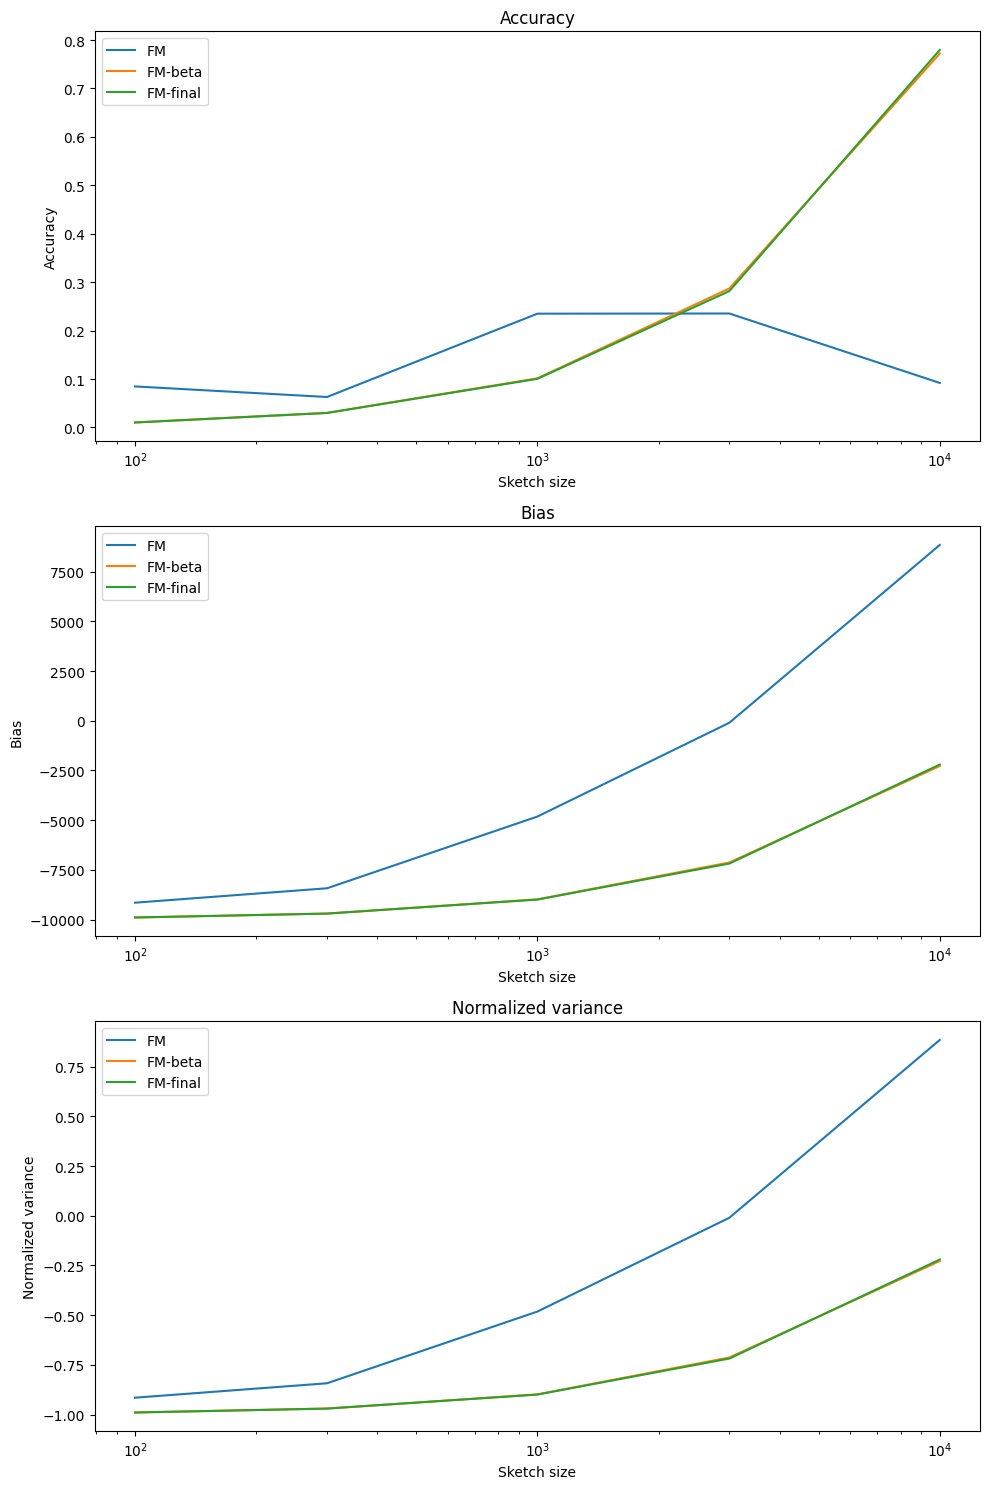

In [274]:
import matplotlib.pyplot as plt

fm_results = {sketch_size: results[i][0] for i, sketch_size in enumerate(sketch_sizes)}
fm_beta_results = {sketch_size: results[i][1] for i, sketch_size in enumerate(sketch_sizes)}
fm_final_results = {sketch_size: results[i][2] for i, sketch_size in enumerate(sketch_sizes)}

def calculate_metrics(estimates: dict) -> dict:
    """
    Calculate the accuracy, bias, and normalized variance of the estimates.
    :param estimates: dictionary of estimates
    :return: dictionary of metrics
    """
    metrics = {}
    for sketch_size, size_estimates in estimates.items():
        metrics[sketch_size] = {
            "accuracy": np.mean([max(0, 1 - abs(est - num_unique_elements) / num_unique_elements) for est in size_estimates]),
            "bias": np.mean([est - num_unique_elements for est in size_estimates]),
            "normalized_variance": np.mean([((est - num_unique_elements) / num_unique_elements) for est in size_estimates])
        }
    return metrics

fm_metrics = calculate_metrics(fm_results)
fm_beta_metrics = calculate_metrics(fm_beta_results)
fm_final_metrics = calculate_metrics(fm_final_results)

# Create a figure and axis
fig, ax = plt.subplots(3, 1, figsize=(10, 15))

# Plot the accuracy
ax[0].plot(sketch_sizes, [fm_metrics[sketch_size]["accuracy"] for sketch_size in sketch_sizes], label="FM")
ax[0].plot(sketch_sizes, [fm_beta_metrics[sketch_size]["accuracy"] for sketch_size in sketch_sizes], label="FM-beta")
ax[0].plot(sketch_sizes, [fm_final_metrics[sketch_size]["accuracy"] for sketch_size in sketch_sizes], label="FM-final")
ax[0].set_xscale("log")
ax[0].set_xlabel("Sketch size")
ax[0].set_ylabel("Accuracy")
ax[0].set_title("Accuracy")
ax[0].legend()

# Plot the bias
ax[1].plot(sketch_sizes, [fm_metrics[sketch_size]["bias"] for sketch_size in sketch_sizes], label="FM")
ax[1].plot(sketch_sizes, [fm_beta_metrics[sketch_size]["bias"] for sketch_size in sketch_sizes], label="FM-beta")
ax[1].plot(sketch_sizes, [fm_final_metrics[sketch_size]["bias"] for sketch_size in sketch_sizes], label="FM-final")
ax[1].set_xscale("log")
ax[1].set_xlabel("Sketch size")
ax[1].set_ylabel("Bias")
ax[1].set_title("Bias")
ax[1].legend()

# Plot the normalized variance
ax[2].plot(sketch_sizes, [fm_metrics[sketch_size]["normalized_variance"] for sketch_size in sketch_sizes], label="FM")
ax[2].plot(sketch_sizes, [fm_beta_metrics[sketch_size]["normalized_variance"] for sketch_size in sketch_sizes], label="FM-beta")
ax[2].plot(sketch_sizes, [fm_final_metrics[sketch_size]["normalized_variance"] for sketch_size in sketch_sizes], label="FM-final")
ax[2].set_xscale("log")
ax[2].set_xlabel("Sketch size")
ax[2].set_ylabel("Normalized variance")
ax[2].set_title("Normalized variance")
ax[2].legend()

plt.tight_layout()
plt.show()